In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import astropy.constants as const
from matplotlib.colors import Normalize as Normalize
import matplotlib.cm
import scipy.interpolate as interpolate
from scipy import stats
from matplotlib.gridspec import GridSpec

In [4]:
def t_phase_folded(t, per, t0):
    t_phase_folded = (t - t0)/per - np.floor((t - t0)/per + 0.5) # centers on zero
    return t_phase_folded

def gen1pagefig(toi, lcnames, rvnames):
    '''
    toi: the planet's toi number. Can be integer or string. Ex: '1855' for toi-1855

    lcnames: array of strings naming the telescopes used to collect the light curves in order of the observation date. If it is
    a tess light curve, write TESS and then the exposure time in seconds. Ex: ['TESS 1800', 'SOAR']

    rvnames: array of strings with the names of the instruments that obtained the RVs in alphabetical order. Ex: ['CHIRON (fiber)', 'CHIRON (slicer)']
    '''

    # Determining which TESS data are being used
    TESS_exptimes = []
    for x in lcnames:
        if 'TESS' in x:
            TESS_exptimes.append(str([int(s) for s in x.split() if s.isdigit()][0]))
    TESS_exptimes = list(set(TESS_exptimes)) # removing duplicates

    # LOADING IN DATA

    # loading median file
    median = pd.read_csv(f'data/TOI-{toi}.MIST.SED.median.csv')

    period = float(median[' median value'][median['#parname'] == 'Period_0']) * u.day
    epoch = float(median[' median value'][median['#parname'] == 'tc_0']) * u.day
    t14 = float(median[' median value'][median['#parname'] == 't14_0']) * u.day
    t14 = (t14.to(u.hr)).value
    gamma = float(median[' median value'][median['#parname'] == 'gamma_0'])
    jitter = float(median[' median value'][median['#parname'] == 'jitter_0'])
    planetmass = float(median[' median value'][median['#parname'] == 'mp_0'])
    planetradius = float(median[' median value'][median['#parname'] == 'rp_0'])
    eccentricity = float(median[' median value'][median['#parname'] == 'e_0'])

    # loading mcmc transit files

    model_names = ['time', 'flux']
    residual_names = ['time', 'residuals', 'error']

    pretty_TESS_1800 = pd.DataFrame(columns=model_names)
    detrended_TESS_1800 = pd.DataFrame(columns=model_names)
    residuals_TESS_1800 = pd.DataFrame(columns=residual_names)

    pretty_TESS_600 = pd.DataFrame(columns=model_names)
    detrended_TESS_600 = pd.DataFrame(columns=model_names)
    residuals_TESS_600 = pd.DataFrame(columns=residual_names)

    pretty_TESS_120 = pd.DataFrame(columns=model_names)
    detrended_TESS_120 = pd.DataFrame(columns=model_names)
    residuals_TESS_120 = pd.DataFrame(columns=residual_names)

    followup_name_index = [] # initializing follow-up lc name index to assign names at the end
    f = 0 # integer required to track the number of follow-up lightcurves

    for i in range(len(lcnames)):
        lc_index = f'{i:03d}'
        pretty_model = pd.read_csv(f'data/TOI-{toi}.MIST.SED.mcmc.prettymodel.transit_{lc_index}.planet_00.txt', sep='\s+', header=None, names=model_names)
        detrended_model = pd.read_csv(f'data/TOI-{toi}.MIST.SED.mcmc.detrendedmodel.transit_{lc_index}.planet_00.txt', sep='\s+', header=None, names=model_names)
        residual = pd.read_csv(f'data/TOI-{toi}.MIST.SED.mcmc.residuals.transit_{lc_index}.txt', sep='\s+', header=None, names=residual_names)

        if lcnames[i] == 'TESS 1800':
            pretty_TESS_1800 = pd.concat([pretty_TESS_1800, pretty_model], ignore_index = True)
            detrended_TESS_1800 = pd.concat([detrended_TESS_1800, detrended_model], ignore_index = True)
            residuals_TESS_1800 = pd.concat([residuals_TESS_1800, residual], ignore_index = True)
        elif lcnames[i] == 'TESS 600':
            pretty_TESS_600 = pd.concat([pretty_TESS_600, pretty_model], ignore_index = True)
            detrended_TESS_600 = pd.concat([detrended_TESS_600, detrended_model], ignore_index = True)
            residuals_TESS_600 = pd.concat([residuals_TESS_600, residual], ignore_index = True)
        elif lcnames[i] == 'TESS 120':
            pretty_TESS_120 = pd.concat([pretty_TESS_120, pretty_model], ignore_index = True)
            detrended_TESS_120 = pd.concat([detrended_TESS_120, detrended_model], ignore_index = True)
            residuals_TESS_120 = pd.concat([residuals_TESS_120, residual], ignore_index = True)         
        else:
            pretty_varname = f'pretty_followup_{f}'
            detrended_varname = f'detrended_followup_{f}'
            residuals_varname = f'residuals_followup_{f}'
            locals()[pretty_varname] = pretty_model # assigning new variable pretty_followup_{f} = pretty_model
            locals()[detrended_varname] = detrended_model
            locals()[residuals_varname] = residual
            followup_name_index.append(i)
            f += 1

    for i in range(len(rvnames)):
        residuals_rv_varname = f'residuals_rv_{i}'
        model_rv_varname = f'model_rv_{i}'

        model_names_rv = ['time', 'rv']
        pretty_rv = pd.read_csv(f'data/TOI-{toi}.MIST.SED.mcmc.rv.ps.prettymodelrv.planet.00.txt', sep='\s+', names=model_names_rv)
        pretty_rv['phase'] = ((pretty_rv.time - epoch)/period.value) - np.floor((pretty_rv.time - epoch)/period.value+0.5)
        pretty_rv_phasesorted = pretty_rv.sort_values('phase')

        residuals_names_rv = ['time', 'residual', 'error']
        locals()[residuals_rv_varname] = pd.read_csv(f'data/TOI-{toi}.MIST.SED.mcmc.residuals.telescope_0{i}.txt', sep='\s+', names=residuals_names_rv)
        locals()[residuals_rv_varname]['phase'] = ((locals()[residuals_rv_varname].time - epoch)/period.value) - np.floor((locals()[residuals_rv_varname].time - epoch)/period.value+0.5)
        locals()[model_rv_varname] = pd.read_csv(f'data/TOI-{toi}.MIST.SED.mcmc.model.telescope_0{i}.txt', sep='\s+', names=model_names_rv)

    # Loading in SED data
    sed_cols = ['filtername', 'wavelength', 'model_flux', 'measured_flux', 'upper_error', 'lower_error', 'residual']
    sed_residuals = pd.read_csv(f'data/TOI-{toi}.MIST.SED.mcmc.sed.residuals.txt', sep='\s+', skiprows=1, header=None, names = sed_cols)

    # MANIPULATING DATA

    # Generating lightcurves for the TESS data
    dic_TESS_1800 = {'time': detrended_TESS_1800.time, 'flux': detrended_TESS_1800.flux + residuals_TESS_1800.residuals + 1}
    lc_TESS_1800 = pd.DataFrame(dic_TESS_1800)
    dic_TESS_600 = {'time': detrended_TESS_600.time, 'flux': detrended_TESS_600.flux + residuals_TESS_600.residuals + 1}
    lc_TESS_600 = pd.DataFrame(dic_TESS_600)
    dic_TESS_120 = {'time': detrended_TESS_120.time, 'flux': detrended_TESS_120.flux + residuals_TESS_120.residuals + 1}
    lc_TESS_120 = pd.DataFrame(dic_TESS_120)

    # Generating lightcurves for the followup data
    for i in range(len(followup_name_index)):
        detrended_varname = f'detrended_followup_{i}'
        residuals_varname = f'residuals_followup_{i}'
        lc_varname = f'lc_followup_{i}'
        dic_followup = {'time': locals()[detrended_varname].time, 'flux': locals()[detrended_varname].flux + locals()[residuals_varname].residuals + 1}
        locals()[lc_varname] = pd.DataFrame(dic_followup)

    # Phase-folding the TESS data
    for exptime in TESS_exptimes:
        lc_varname = 'lc_TESS_' + exptime
        pretty_varname = 'pretty_TESS_' + exptime
        locals()[lc_varname].time = t_phase_folded(locals()[lc_varname].time, period, epoch)*period.to(u.hr)
        locals()[pretty_varname].time = t_phase_folded(locals()[pretty_varname].time, period, epoch)*period.to(u.hr)

    # Phase-folding the followup data
    for i in range(len(followup_name_index)):
        lc_varname = f'lc_followup_{i}'
        pretty_varname = f'pretty_followup_{i}'
        locals()[lc_varname].time = t_phase_folded(locals()[lc_varname].time, period, epoch)*period.to(u.hr)
        locals()[pretty_varname].time = t_phase_folded(locals()[pretty_varname].time, period, epoch)*period.to(u.hr)

    # # binning the data
    # binwidth = t14 / 10

    # nbins_TESS = int((np.max(lc_TESS.time) - np.min(lc_TESS.time))/binwidth)

    # lc_TESS_binned_time = stats.binned_statistic(lc_TESS.time, lc_TESS.time, bins = nbins_TESS)[0]
    # lc_TESS_binned_flux = stats.binned_statistic(lc_TESS.time, lc_TESS.flux, bins = nbins_TESS)[0]

    # nbins_followup = int((np.max(lc_followup.time) - np.min(lc_followup.time))/binwidth)

    # lc_followup_binned_time = stats.binned_statistic(lc_followup.time, lc_followup.time, bins = nbins_followup)[0]
    # lc_followup_binned_flux = stats.binned_statistic(lc_followup.time, lc_followup.flux, bins = nbins_followup)[0]

    # # median combining and cleaning up the TESS model
    # pretty_TESS = pretty_TESS.sort_values('time')
    # pretty_TESS_binned_time = stats.binned_statistic(pretty_TESS.time, pretty_TESS.time, bins = nbins_TESS * 2)[0]
    # pretty_TESS_binned_flux = stats.binned_statistic(pretty_TESS.time, pretty_TESS.flux, bins = nbins_TESS * 2)[0]

    # Calculating RVs
    for i in range(len(rvnames)):
        rvs_varname = f'rvs_{i}'
        rvs_error_varname = f'rv_error_{i}'
        model_rv_varname = f'model_rv_{i}'
        residuals_rv_varname = f'residuals_rv_{i}'
        locals()[rvs_varname] = locals()[model_rv_varname].rv + locals()[residuals_rv_varname].residual - gamma
        locals()[rvs_error_varname] = (locals()[residuals_rv_varname].error**2 + jitter)**(1/2)

    # PLOTTING

    # defining a list of colors to choose from when plotting. Feel free to change or add more!
    colors = ['#34568B', '#95DEE3', '#88B04B', '#955251', '#009B77', '#DD4124', '#5B5EA6', '#9B2335', '#E6AF91', '#D65076', '#821ea6', '#d1af19']

    # Setting up the figure
    fig, axs = plt.subplots(ncols=2, nrows=3)
    fig.set_figheight(22)
    fig.set_figwidth(17)
    fig.suptitle(f'TOI-{toi}\n', fontsize=20, fontweight='bold')
    fig.text(0.5, 0.95, f'P = {round(period.value, 3)} d | R$_P$ = {planetradius} R$_J$ | M$_P$ = {planetmass} M$_J$ | e = {eccentricity}', ha='center', fontsize=17)   

    # Making the top left plot take up two spaces
    gs = axs[0, 0].get_gridspec()
    # remove the underlying axes
    for ax in axs[0:2, 0]:
        ax.remove()
    ax1 = fig.add_subplot(gs[0:2, 0])

    # Transits (top left)
    TESS_lc_index = 0 # keeps track of the TESS lightcurves to space each lightcurve
    for exptime in TESS_exptimes:
        pretty_varname = 'pretty_TESS_' + exptime
        lc_varname = 'lc_TESS_' + exptime
        locals()[pretty_varname].sort_values('time', inplace=True) # sorting model

        # separates each lightcurve by 0.025
        model=ax1.plot(locals()[pretty_varname].time, locals()[pretty_varname].flux + 1 - 0.025 * TESS_lc_index, c = 'k', zorder=2, linewidth=3)
        ax1.scatter(locals()[lc_varname].time, locals()[lc_varname].flux - 0.025 * TESS_lc_index, ls = 'None', c=colors[TESS_lc_index], s = 100, alpha = 0.7, \
                edgecolors='#000000', zorder = 1, label = 'TESS ' + exptime + 's')
        # tess=ax1.scatter(lc_TESS_binned_time, lc_TESS_binned_flux, ls = 'None', c='#9F3BC2', s = 125, alpha = 1, \
                # edgecolors='#000000', zorder = 10, label='TESS')
        TESS_lc_index += 1

    for i in range(len(followup_name_index)):
        pretty_varname = f'pretty_followup_{i}'
        lc_varname = f'lc_followup_{i}'

        locals()[pretty_varname].sort_values('time', inplace=True) # sorting model

        ax1.plot(locals()[pretty_varname].time, locals()[pretty_varname].flux + 1 - 0.025 * (i + TESS_lc_index), c = 'k', zorder=2, linewidth=3)
        ax1.scatter(locals()[lc_varname].time, locals()[lc_varname].flux - 0.025 * (i + TESS_lc_index), ls = 'None', c=colors[i + len(TESS_exptimes)], s = 100, alpha = 0.7, \
                edgecolors='#000000', zorder = 1, label = lcnames[followup_name_index[i]])
        # followup=ax1.scatter(lc_followup_binned_time, lc_followup_binned_flux-0.025, ls = 'None', c='#7BA2F1', \
                # s = 125, alpha = 1, edgecolors='#000000', zorder = 10, label='TFOP')

    leg=ax1.legend(loc = 4, fontsize = 15)

    xmin = -t14/2 - 1 # setting x limits based on the transit duration
    xmax = t14/2 + 1
    ax1.set_xlim([xmin,xmax])

    ax1.set_xlabel('Time Since Conjunction [Hours]', fontsize = 20)
    ax1.set_ylabel('Normalized Flux', fontsize = 20)

    ax1.tick_params(which = 'both', direction = 'inout')
    ax1.tick_params(labelsize = 20, length = 10, width=2)
    ax1.tick_params(which = 'minor', length = 7, width = 1)
    ax1.tick_params(which='both')

    # RVs (TOP RIGHT)

    axs[0, 1].remove()
    nested_gs = gs[0, 1].subgridspec(2, 1, height_ratios=[1, 0.4], hspace=0)
    ax2_upper = fig.add_subplot(nested_gs[0])
    ax2_lower = fig.add_subplot(nested_gs[1])

    ax2_upper.set_xlim(np.min(pretty_rv.time - 2457000),np.max(pretty_rv.time - 2457000))
    ax2_lower.set_xlim(np.min(pretty_rv.time - 2457000),np.max(pretty_rv.time - 2457000))
    ax2_lower.set_xlabel('Time [BJD$_{\mathrm{TDB}} - 2457000$]', fontsize = 20)
    ax2_upper.set_ylabel('RV [m/s]', fontsize = 20)
    ax2_lower.set_ylabel('O-C [m/s]', fontsize = 20)

    ax2_upper.tick_params(which = 'major', direction = 'inout',labelsize = 20, length = 10, width=2,axis='y')
    ax2_lower.tick_params(which = 'major', direction = 'inout',labelsize = 20, length = 10, width=2)

    ax2_upper.set_ylim(-420, 420)

    ax2_upper.plot(pretty_rv.time - 2457000, pretty_rv.rv, c = 'k', zorder=10, lw = 0.5, label = 'EXOFASTv2', alpha=0.7)

    for i in range(len(rvnames)):
        residuals_rv_varname = f'residuals_rv_{i}'
        rvs_varname = f'rvs_{i}'
        rvs_error_varname = f'rv_error_{i}'

        ax2_upper.errorbar(locals()[residuals_rv_varname].time - 2457000, locals()[rvs_varname], yerr=locals()[rvs_error_varname], fmt='o', mfc='#03913e', \
                        mec='k', ecolor='#03913e', capsize=4, ls='None', label='TRES')
        ax2_lower.errorbar(locals()[residuals_rv_varname].time - 2457000, locals()[residuals_rv_varname].residual, yerr=locals()[rvs_error_varname], \
                        fmt='o', mfc='#03913e', mec='k', ecolor='#03913e', capsize=4, ls='None')
        
    ax2_lower.axhline(0, ls='--', c='grey', lw = 2)
    ax2_upper.legend(fontsize = 15)

    # RVs vs. Phase

    axs[1, 1].remove()
    nested_gs = gs[1, 1].subgridspec(2, 1, height_ratios=[1, 0.4], hspace=0)
    ax3_upper = fig.add_subplot(nested_gs[0])
    ax3_lower = fig.add_subplot(nested_gs[1])
    ax3_upper.set_xlim(-0.5, 0.5)
    ax3_lower.set_xlim(-0.5, 0.5)
    ax3_lower.set_xlabel('Phase', fontsize = 20)
    ax3_upper.set_ylabel('RV [m/s]', fontsize = 20)
    ax3_lower.set_ylabel('O-C [m/s]', fontsize = 20)

    ax3_upper.tick_params(which = 'major', labelsize = 20, length = 10, width=2, axis='y')
    ax3_lower.tick_params(which = 'major', direction = 'inout', labelsize = 20, length = 10, width=2)

    ax3_upper.plot(pretty_rv_phasesorted.phase, pretty_rv_phasesorted.rv, c = 'k', zorder=10, lw = 2, label = 'EXOFASTv2', alpha=0.7)

    for i in range(len(rvnames)):
        residuals_rv_varname = f'residuals_rv_{i}'
        rvs_varname = f'rvs_{i}'
        rvs_error_varname = f'rv_error_{i}'

        ax3_upper.errorbar(locals()[residuals_rv_varname].phase, locals()[rvs_varname], yerr=locals()[rvs_error_varname], fmt='o', mfc='#03913e', mec='k', ecolor='#03913e', capsize=4,\
                ls='None', label='TRES')
        ax3_lower.errorbar(locals()[residuals_rv_varname].phase, locals()[residuals_rv_varname].residual, yerr=locals()[rvs_error_varname], fmt='o', mfc='#03913e', mec='k',\
                ecolor='#03913e', capsize=4, ls='None')

    ax3_lower.axhline(0, ls='--', c='grey', lw = 2)
    ax3_upper.legend(fontsize = 15)

    # SED Plot

    axs[2, 0].remove()
    nested_gs = gs[2, 0].subgridspec(2, 1, height_ratios=[1, 0.4], hspace=0)
    ax4_upper = fig.add_subplot(nested_gs[0])
    ax4_lower = fig.add_subplot(nested_gs[1])
    ax4_upper.set_ylabel('Flux [erg s$^{-1}$ cm$^{-2}$]', fontsize = 20)
    ax4_lower.set_xlabel('Wavelength [$\mu$m]', fontsize = 20)
    ax4_lower.set_ylabel('O-C [erg s$^{-1}$ cm$^{-2}$]', fontsize = 20)

    ax4_upper.tick_params(which = 'major', direction = 'inout',labelsize = 20, length = 10, width=2, axis='y')
    ax4_upper.set_xticks([])
    ax4_lower.tick_params(which = 'major', direction = 'inout',labelsize = 20, length = 10, width=2)

    ax4_upper.errorbar(sed_residuals.wavelength, sed_residuals.measured_flux, yerr=[sed_residuals.lower_error, sed_residuals.upper_error], fmt='.', markersize=8, mfc='#ff3126', mec='#ff3126',\
                ecolor='#ff3126', capsize=4, ls='None', label = 'Observations') # Are x errors the width of the wavelength band or where do we get these?
    # ax4_upper.set_yscale('log')

    ax4_upper.plot(sed_residuals.wavelength, sed_residuals.model_flux, lw=2, color='k', label='EXOFASTv2')

    ax4_lower.errorbar(sed_residuals.wavelength, sed_residuals.residual, yerr=[sed_residuals.lower_error, sed_residuals.upper_error], fmt='.', markersize=8, mfc='#ff3126', mec='#ff3126',\
                ecolor='#ff3126', capsize=4, ls='None', label = 'Observations') # Are x errors the width of the wavelength band or where do we get these?

    ax4_lower.axhline(0, ls='--', color='grey', lw = 2)
    ax4_lower.set_ylim(-3e-11, 3e-11)

    ax4_upper.legend(fontsize = 15)

    # MIST Plot

    # Add some space between subplots
    plt.tight_layout(pad=3, h_pad=1)
    plt.savefig(f'fullpagefig_{toi}.png')


120
1
600
2
1800
3


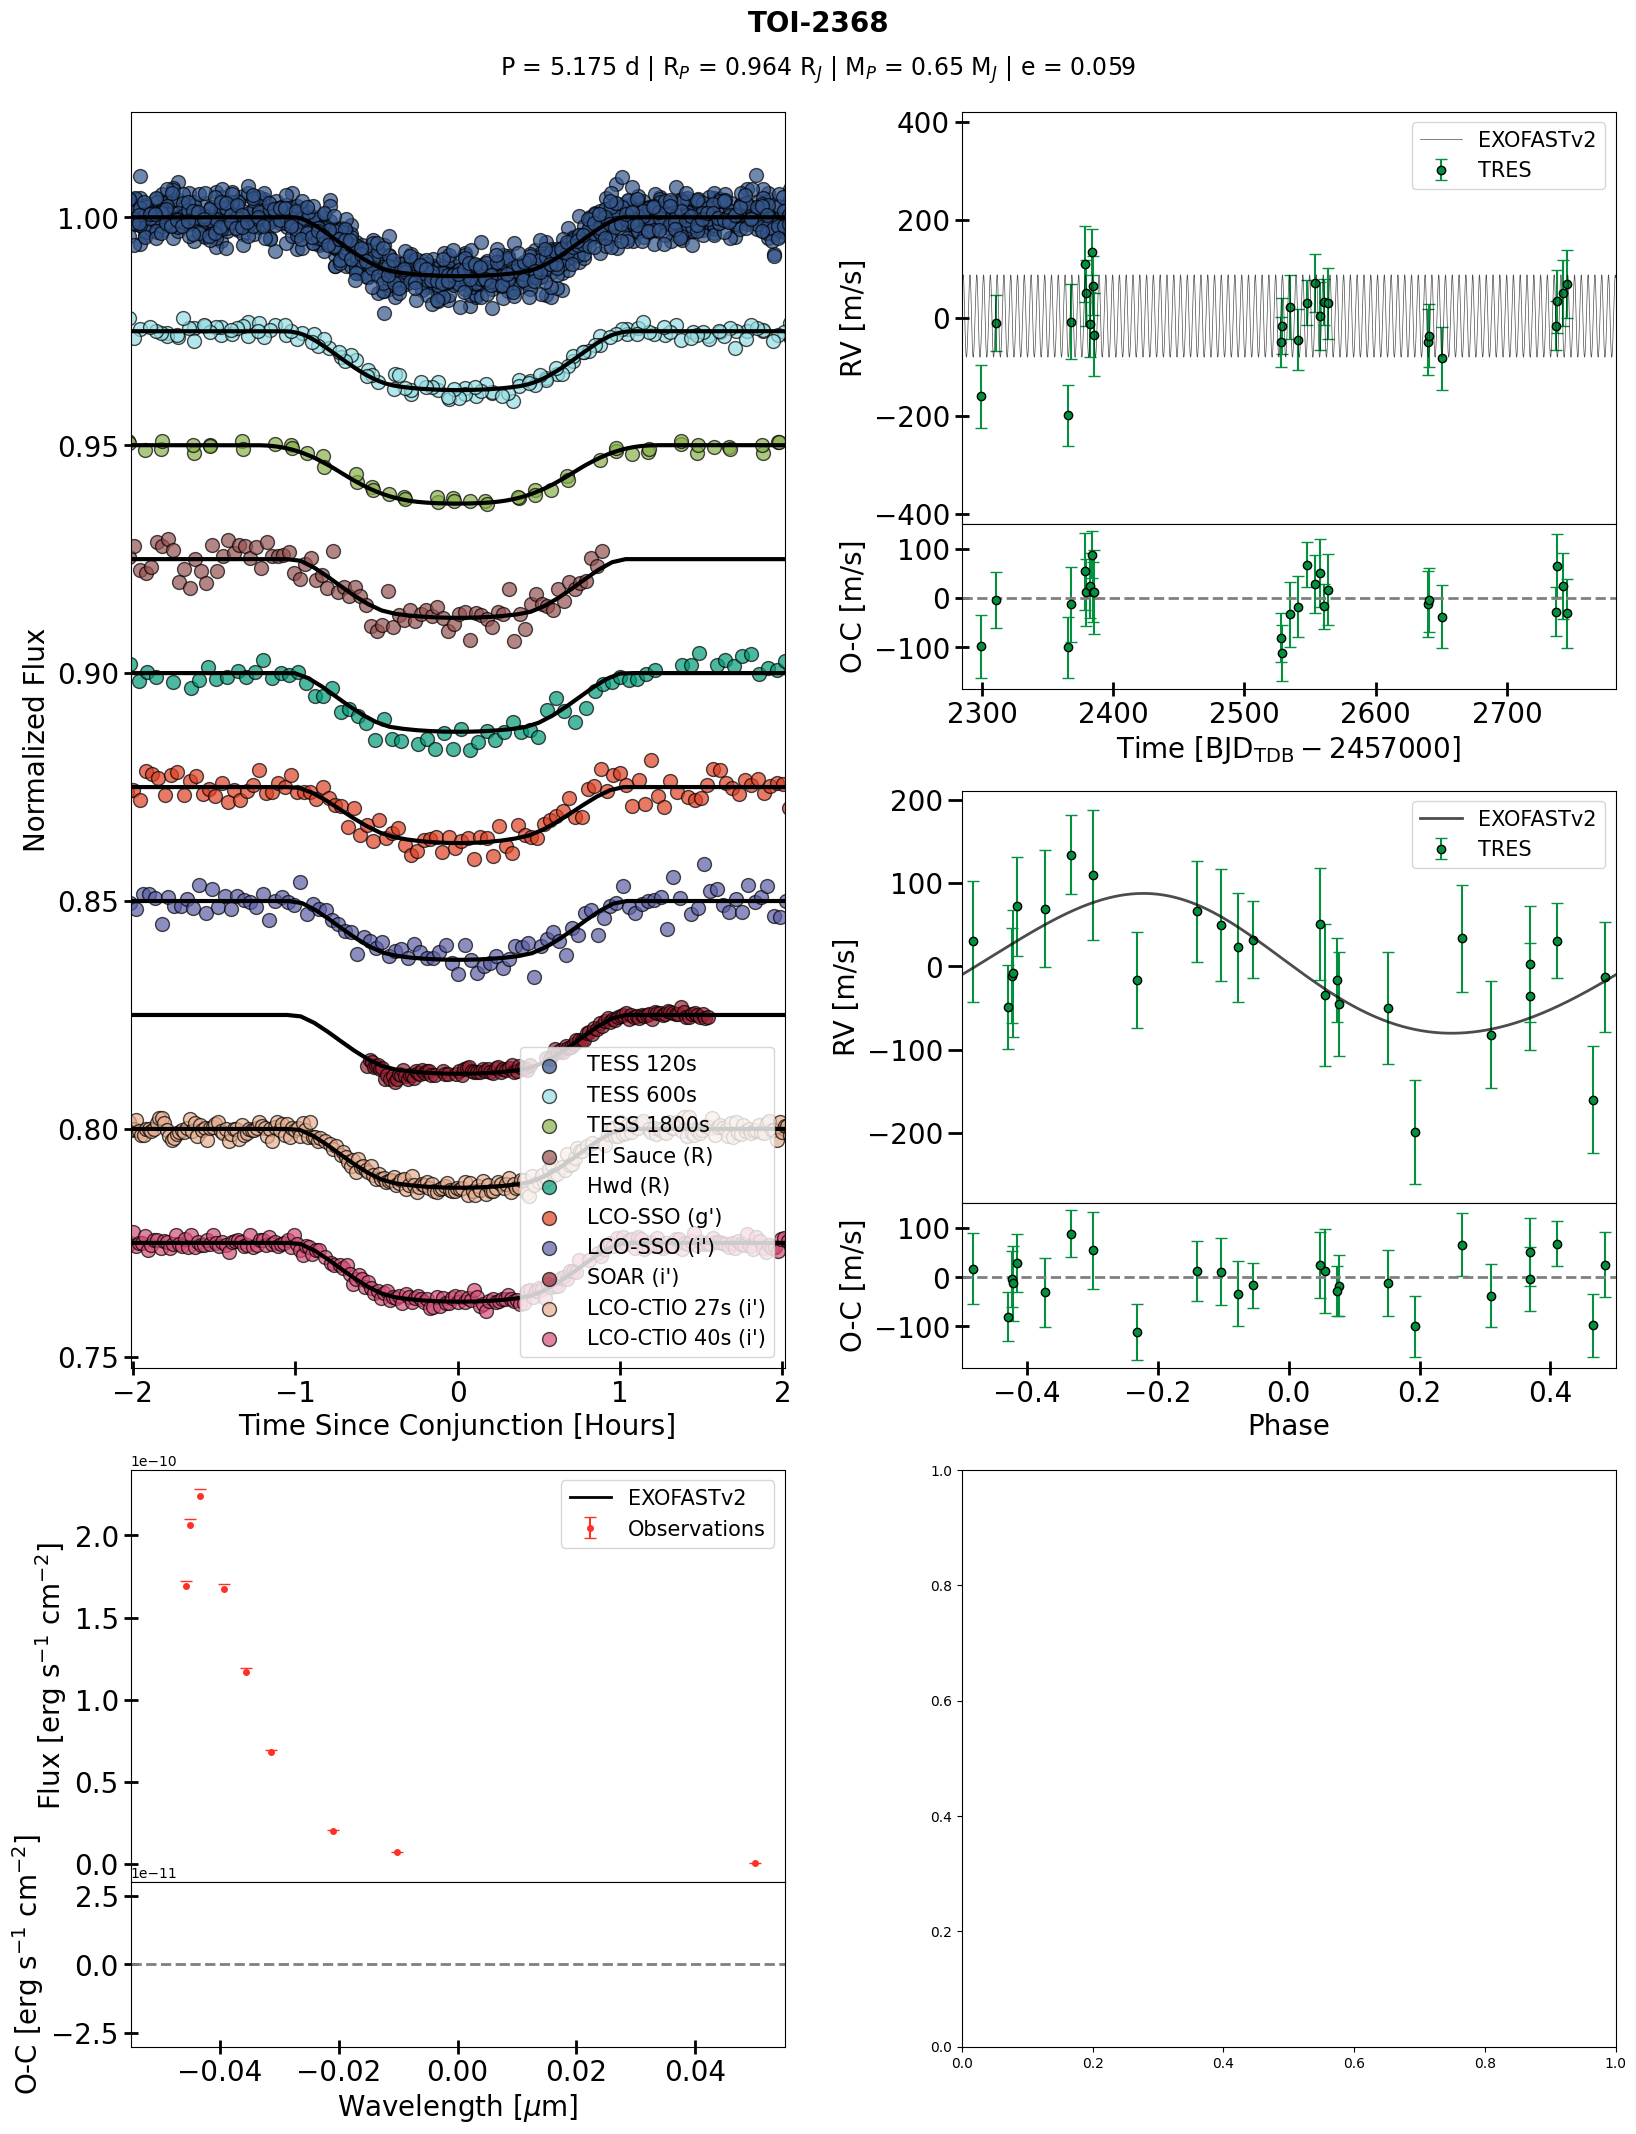

In [5]:
toi = 2368
lcnames_1855 = ['TESS 1800', 'Bergeron (r\')', 'MuSCAT2 (g\')', 'MuSCAT2 (i\')', 'MuSCAT2 (r\')', 'MuSCAT2 (z\')', 'DSW (g\')', 'LCO-CTIO (z\')', 'TESS 120', 'SOAR (i\')']
lcnames_2368 = ['TESS 1800', 'TESS 1800', 'El Sauce (R)', 'Hwd (R)', 'TESS 600', 'LCO-SSO (g\')', 'LCO-SSO (i\')', 'TESS 600', 'SOAR (i\')', 'TESS 120', \
    'TESS 120', 'LCO-CTIO 27s (i\')', 'LCO-CTIO 40s (i\')']
rvnames = ['CHIRON']
gen1pagefig(toi, lcnames_2368, rvnames)

### Things I need to do:
- Add implementation for multiple different RV instruments (change gamma import)
- Update SED plot
- Add MIST plot